## Pneumonia Detection Challenge

The goal is to build a pneumonia detection system, to locate the position of inflammation in an image.


In [1]:
import numpy as np 
import pandas as pd
import tensorflow as tf
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pydicom as pyd
from tqdm import tqdm
from sklearn.model_selection import train_test_split
import albumentations as A
import cv2
from tensorflow.keras.applications import EfficientNetB0
from tensorflow.keras.models import Sequential
from tensorflow.keras.utils import Sequence
from tensorflow.keras import layers

In [2]:
images_path = 'input/stage_2_train_images'
train_labels_df = pd.read_csv('input/stage_2_train_labels.csv')
label_meta_data = pd.read_csv('input/stage_2_detailed_class_info.csv')

In [3]:
train_labels_df.head(10)

,patientId,x,y,width,height,Target
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1


In [4]:
label_meta_data.head(10)

,patientId,class
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
5,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity
6,00569f44-917d-4c86-a842-81832af98c30,No Lung Opacity / Not Normal
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,No Lung Opacity / Not Normal
8,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity
9,00704310-78a8-4b38-8475-49f4573b2dbb,Lung Opacity


In [5]:
print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (30227, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


In [6]:
train_labels_df.drop_duplicates(inplace=True)
label_meta_data.drop_duplicates(inplace=True)
print('Size of Dataset 1: ',train_labels_df.shape)
print('Size of Dataset 2: ',label_meta_data.shape)
print('Number of Unique X-Rays in Dataset 1 : ',train_labels_df['patientId'].nunique())
print('Number of Unique X-Rays in Dataset 2 : ',label_meta_data['patientId'].nunique())

Size of Dataset 1:  (30227, 6)
Size of Dataset 2:  (26684, 2)
Number of Unique X-Rays in Dataset 1 :  26684
Number of Unique X-Rays in Dataset 2 :  26684


Patient ID: 0004cfab-14fd-4e49-80ba-63a80b6bddd6, Age: 51, Sex: F


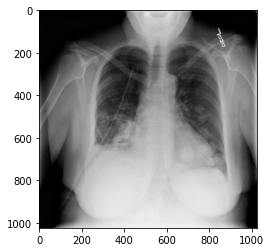

Patient ID: 00313ee0-9eaa-42f4-b0ab-c148ed3241cd, Age: 48, Sex: F


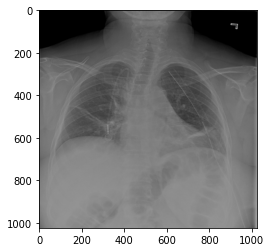

Patient ID: 00322d4d-1c29-4943-afc9-b6754be640eb, Age: 19, Sex: M


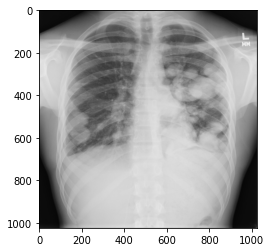

In [7]:
## read some of the dcm files
ctr = 0
for id in label_meta_data['patientId']:
    ds = pyd.dcmread(os.path.join(images_path, id+'.dcm'))
    print('Patient ID: {}, Age: {}, Sex: {}'.format(id, ds.PatientAge, ds.PatientSex))
    plt.imshow(cv2.cvtColor(ds.pixel_array, cv2.COLOR_BGR2RGB))
    plt.show()
    ctr +=1
    if ctr == 3:
        break
    

In [8]:
patient_info_df = pd.DataFrame(columns=['patientId', 'age','sex'])
ctr = 0;
for id in label_meta_data['patientId']:
    ds = pyd.dcmread(os.path.join(images_path, id+'.dcm'))
    patient_info_df.loc[ctr] = [id, ds.PatientAge, ds.PatientSex]
    ctr +=1

In [9]:
display(patient_info_df)

,patientId,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,32,F
...,...,...,...
26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,47,F
26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,54,M
26681,c1edf42b-5958-47ff-a1e7-4f23d99583ba,46,F
26682,c1f6b555-2eb1-4231-98f6-50a963976431,45,M


In [10]:
# Merging this patient information with the exiting meta data
patient_info_df = pd.merge(label_meta_data,patient_info_df,on="patientId")
patient_info_df

,patientId,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,Lung Opacity,32,F
...,...,...,...,...
26679,c1e73a4e-7afe-4ec5-8af6-ce8315d7a2f2,Lung Opacity,47,F
26680,c1ec14ff-f6d7-4b38-b0cb-fe07041cbdc8,Lung Opacity,54,M
26681,c1edf42b-5958-47ff-a1e7-4f23d99583ba,Normal,46,F
26682,c1f6b555-2eb1-4231-98f6-50a963976431,Normal,45,M


In [11]:
merged_data_info = pd.merge(train_labels_df,patient_info_df,on="patientId")
merged_data_info.head(10)

,patientId,x,y,width,height,Target,class,age,sex
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,F
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,F
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,M
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,M
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,F
5,00436515-870c-4b36-a041-de91049b9ab4,562.0,152.0,256.0,453.0,1,Lung Opacity,32,F
6,00569f44-917d-4c86-a842-81832af98c30,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,54,M
7,006cec2e-6ce2-4549-bffa-eadfcd1e9970,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,78,M
8,00704310-78a8-4b38-8475-49f4573b2dbb,323.0,577.0,160.0,104.0,1,Lung Opacity,75,M
9,00704310-78a8-4b38-8475-49f4573b2dbb,695.0,575.0,162.0,137.0,1,Lung Opacity,75,M


In [12]:
merged_data_info.shape

(30227, 9)

In [13]:
print(merged_data_info.shape)
print(merged_data_info.isna().sum())

(30227, 9)
patientId        0
x            20672
y            20672
width        20672
height       20672
Target           0
class            0
age              0
sex              0
dtype: int64


In [14]:
print('Minimum Age in the dataset:', merged_data_info['age'].min())
print('Maximum Age in the dataset', merged_data_info['age'].max())

merged_data_info.columns = merged_data_info.columns.str.strip()
merged_data_info['sex']=merged_data_info['sex'].replace({ 'M' : 0, 'F' : 1  })
merged_data_info['label']=merged_data_info['class']
merged_data_info['label']=merged_data_info['label'].replace({ 'Normal' : 0, 'Lung Opacity' : 1, 'No Lung Opacity / Not Normal' : 2 })



Minimum Age in the dataset: 1
Maximum Age in the dataset 92


In [15]:
merged_data_info['age'] = merged_data_info['age'].astype('int64')

In [16]:
merged_data_info.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30227 entries, 0 to 30226
Data columns (total 10 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   patientId  30227 non-null  object 
 1   x          9555 non-null   float64
 2   y          9555 non-null   float64
 3   width      9555 non-null   float64
 4   height     9555 non-null   float64
 5   Target     30227 non-null  int64  
 6   class      30227 non-null  object 
 7   age        30227 non-null  int64  
 8   sex        30227 non-null  int64  
 9   label      30227 non-null  int64  
dtypes: float64(4), int64(4), object(2)
memory usage: 2.5+ MB


## Target Distribution

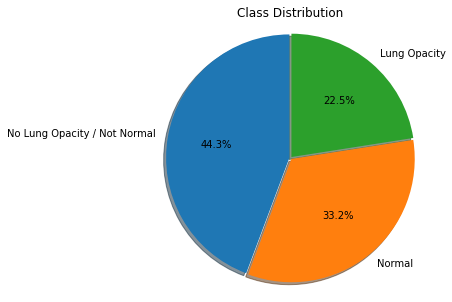

In [17]:
label_count=label_meta_data['class'].value_counts()
explode = (0.01,0.01,0.01)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=label_count.index, autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Class Distribution')
plt.show()

In [18]:
merged_data_info.head()

,patientId,x,y,width,height,Target,class,age,sex,label
0,0004cfab-14fd-4e49-80ba-63a80b6bddd6,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,51,1,2
1,00313ee0-9eaa-42f4-b0ab-c148ed3241cd,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,48,1,2
2,00322d4d-1c29-4943-afc9-b6754be640eb,NaN,NaN,NaN,NaN,0,No Lung Opacity / Not Normal,19,0,2
3,003d8fa0-6bf1-40ed-b54c-ac657f8495c5,NaN,NaN,NaN,NaN,0,Normal,28,0,0
4,00436515-870c-4b36-a041-de91049b9ab4,264.0,152.0,213.0,379.0,1,Lung Opacity,32,1,1


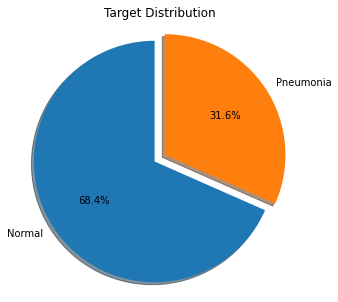

In [19]:
# lets take a look at our Target Distribution
label_count=merged_data_info['Target'].value_counts()
explode = (0.1,0.0)  

fig1, ax1 = plt.subplots(figsize=(5,5))
ax1.pie(label_count.values, explode=explode, labels=['Normal','Pneumonia'], autopct='%1.1f%%',
        shadow=True, startangle=90)
ax1.axis('equal') 
plt.title('Target Distribution')
plt.show()

### Visualization of the Images

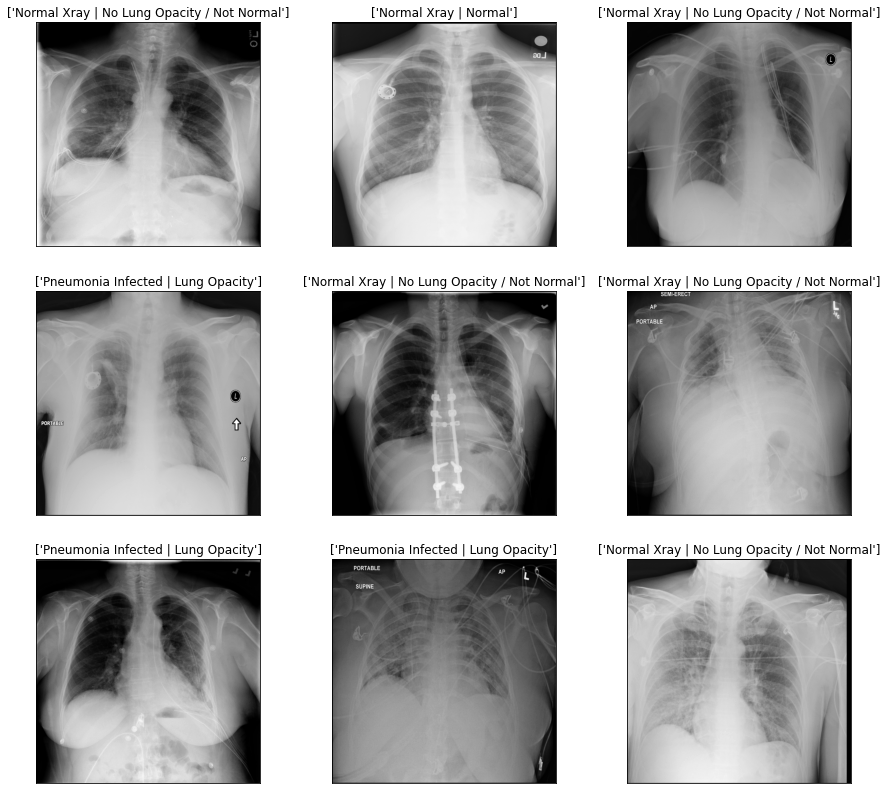

In [20]:
r=c=3
fig= plt.figure(figsize=(15,14))
for i in range(1,r*c+1):
    id_= np.random.choice(merged_data_info['patientId'].values)
    label_0= np.unique(merged_data_info['Target'][merged_data_info['patientId']==id_])
    label_1= np.unique(merged_data_info['class'][merged_data_info['patientId']==id_])
    
    #read xray
    img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
    fig.add_subplot(r,c,i)
    plt.imshow(img,cmap='gray')
    if label_0==1:
        plt.title('Pneumonia Infected'+' | '+label_1)
    else:
        plt.title('Normal Xray'+' | '+label_1)
    plt.xticks([])
    plt.yticks([])

### Visualization of the areas of inflammation

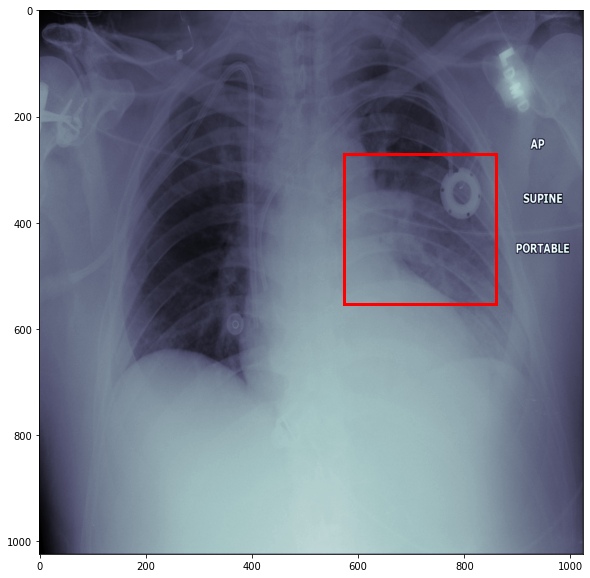

In [25]:
id_= np.random.choice(merged_data_info[merged_data_info['Target'] == 1]['patientId'].values)
class_=merged_data_info['class'][merged_data_info['patientId']==id_]

plt.figure(figsize=(15,10))
current_axis = plt.gca()
img=pyd.read_file(os.path.join(images_path,id_+'.dcm')).pixel_array
plt.imshow(img, cmap='bone')


current_axis = plt.gca()
boxes=train_labels_df[['x','y','width','height']][merged_data_info['patientId']==id_].values

for box in boxes:
    x=box[0]
    y=box[1]
    w=box[2]
    h=box[3]
    current_axis.add_patch(plt.Rectangle((x, y), w, h, 
                                         color='red', fill=False, linewidth=3))

<AxesSubplot:xlabel='Target', ylabel='count'>

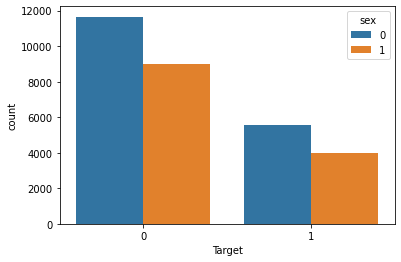

In [22]:
sns.countplot(x=merged_data_info['Target'], hue=merged_data_info['sex'])